In [1]:
import numpy as np
from numpy.random import random, choice
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from gym.envs.toy_text.frozen_lake import generate_random_map

In [2]:
desc = generate_random_map(size=16, p=1.0)
env = gym.make('FrozenLake-v1', is_slippery=False, new_step_api=True, desc=desc)

In [3]:
print("Action space = ", env.action_space)
print("Observation space = ", env.observation_space)

Action space =  Discrete(4)
Observation space =  Discrete(256)


In [4]:
actionsDict = {}
actionsDict[0] = "  L  "
actionsDict[1] = "  D  "
actionsDict[2] = "  R  "
actionsDict[3] = "  U  "

actionsDictInv = {}
actionsDictInv["L"] = 0
actionsDictInv["D"] = 1
actionsDictInv["R"] = 2
actionsDictInv["U"] = 3

In [5]:
env.reset()
# env.render()

0

In [6]:
optimalPolicy = ["L/D/R","  U  ","  U  ","  U  ",
                 "  L  ","  -  "," L/R ","  -  ",
                 "  U  ","  D  ","  L  ","  -  ",
                 "  -  ","  R  ","  D  ","  !  "]
    
print("Optimal policy:")
idxs = [0,4,8,12]
for idx in idxs:
    print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
          optimalPolicy[idx+2], optimalPolicy[idx+3])

Optimal policy:
L/D/R   U     U     U  
  L     -    L/R    -  
  U     D     L     -  
  -     R     D     !  


In [7]:
def action_epsilon_greedy(q, s, epsilon=0.05):
    if np.random.rand() > epsilon:
        return np.argmax(q[s])
    return np.random.randint(4)

def get_action_epsilon_greedy(epsilon):
    return lambda q,s: action_epsilon_greedy(q, s, epsilon=epsilon)

In [8]:
def greedy_policy(q, s):
    return np.argmax(q[s])

In [9]:
def average_performance(policy_fct, q):
    acc_returns = 0.
    n = 500
    for i in range(n):
        done, truncated = False, False
        s = env.reset()
        while not done and not truncated:
            a = policy_fct(q, s)
            (s, reward, done, truncated, info) = env.step(a)
            acc_returns += reward
    return acc_returns/n

In [10]:
# parameters for sarsa(lambda)
episodes = 8000
STEPS = 2000
gamma = 0.9

alpha_crtic = 0.02
alpha_actor = 0.02

epsilon_start = 0.2
epsilon_end = 0.001
epsilon_annealing_stop = int(episodes/2)

eligibility_decay = 0.3

In [11]:
# q = np.ones((env.observation_space.n, env.action_space.n))
# # Set q(terminal,*) equal to 0
# q[5,:] = 0.0
# q[7,:] = 0.0
# q[11,:] = 0.0
# q[12,:] = 0.0
# q[15,:] = 0.0
performance = np.ndarray(episodes//STEPS)


v = np.random.rand(env.observation_space.n)
pi = np.zeros((env.observation_space.n, env.action_space.n))

In [12]:
for episode in range(episodes):

    inew = min(episode,epsilon_annealing_stop)
    epsilon = (epsilon_start * (epsilon_annealing_stop - inew) + epsilon_end * inew) / epsilon_annealing_stop
    
    E_actor = np.zeros((env.observation_space.n, env.action_space.n))
    E_critic = np.zeros(env.observation_space.n)
    
    
    state = env.reset()
    action = action_epsilon_greedy(pi, state, epsilon)

    while True:

        (new_state, reward, done, truncated, info) = env.step(action)
        
        new_action = action_epsilon_greedy(pi, new_state, epsilon)

        E_actor[state, action] = 1
        
        td_error = reward + gamma * v[new_state] - v[state]

        E_critic[state] = 1

        v = v + alpha_crtic * td_error * E_critic
        E_critic = eligibility_decay * gamma * E_critic

        pi = pi + alpha_actor * td_error * E_actor 
        E_actor = eligibility_decay * gamma * E_actor
        
        state, action = new_state, new_action

        if done or truncated:
            break

    # only for plotting the performance, not part of the algorithm 
    if episode%STEPS == 0:
        performance[episode//STEPS] = average_performance(get_action_epsilon_greedy(epsilon), q=pi)

: 

Text(0, 0.5, 'Average reward of an epoch')

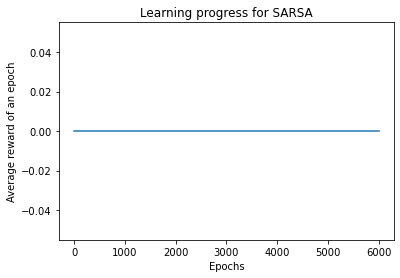

In [13]:
plt.plot(STEPS*np.arange(episodes//STEPS), performance)
plt.xlabel("Epochs")
plt.title("Learning progress for SARSA")
plt.ylabel("Average reward of an epoch")

In [30]:
greedyPolicyAvgPerf = average_performance(greedy_policy, q=pi)
print("Greedy policy SARSA performance =", greedyPolicyAvgPerf) 

Greedy policy SARSA performance = 0.0


In [31]:
q = pi
q = np.round(q,3)
print("(A,S) Value function =", q.shape)
print("First row")
print(q[0:4,:])
print("Second row")
print(q[4:8,:])
print("Third row")
print(q[8:12,:])
print("Fourth row")
print(q[12:16,:])

(A,S) Value function = (256, 4)
First row
[[ 0.005 -0.082  0.427  0.005]
 [-0.128  0.111 -0.303 -0.109]
 [ 0.507  0.055 -0.032  0.002]
 [ 0.005  0.007  0.061  0.   ]]
Second row
[[-0.034 -0.055 -0.062 -0.035]
 [ 0.08   0.     0.     0.003]
 [-0.005  0.     0.     0.   ]
 [-0.01   0.     0.    -0.003]]
Third row
[[0.01 0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]]
Fourth row
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [32]:
policyFound = [actionsDict[np.argmax(q[0,:])],actionsDict[np.argmax(q[1,:])],actionsDict[np.argmax(q[2,:])],actionsDict[np.argmax(q[3,:])],
               actionsDict[np.argmax(q[4,:])],actionsDict[np.argmax(q[5,:])],actionsDict[np.argmax(q[6,:])],actionsDict[np.argmax(q[6,:])],
               actionsDict[np.argmax(q[8,:])],actionsDict[np.argmax(q[9,:])],actionsDict[np.argmax(q[10,:])],actionsDict[np.argmax(q[11,:])],
               actionsDict[np.argmax(q[12,:])],actionsDict[np.argmax(q[13,:])],actionsDict[np.argmax(q[14,:])],"  !  "]
print("Greedy policy found:")
idxs = [0,4,8,12]
for idx in idxs:
    print(policyFound[idx+0], policyFound[idx+1], 
          policyFound[idx+2], policyFound[idx+3])

print(" ")

print("Optimal policy:")
idxs = [0,4,8,12]
for idx in idxs:
    print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
          optimalPolicy[idx+2], optimalPolicy[idx+3])

env.close()

Greedy policy found:
  R     D     L     R  
  L     L     D     D  
  L     L     L     L  
  L     L     L     !  
 
Optimal policy:
L/D/R   U     U     U  
  L     -    L/R    -  
  U     D     L     -  
  -     R     D     !  
